In [15]:
import os
import matplotlib.pyplot as plt
import CGRtools
import multiprocessing

from tqdm import tqdm
from rdkit import Chem

def cgr_representation(rxn_smiles):
    r = CGRtools.smiles(rxn_smiles)
    r.clean2d()
    cgr = ~r
    return cgr.__str__()

def mp_wrapper_cgr(lines, ncpus=48):
    rxn_smiles_list, reaction_id_list = list(zip(*[line.split("\t") for line in lines]))
    with multiprocessing.Pool(processes=ncpus) as pool:
        cgr_list = pool.map(cgr_representation, rxn_smiles_list)
    return {reaction_id: cgr for reaction_id, cgr in zip(reaction_id_list, cgr_list)}

fractions = [3, 5, 10, 15, 20]
thresholds = [1, 3, 5]

In [16]:
golden_data_path = "../data_USPTO_50k_coley/USPTO_50k_coley.txt"
with open(golden_data_path, "r") as f:
    golden_lines = f.readlines()
golden_id2cgr_dict = mp_wrapper_cgr(golden_lines)
num_total_data = len(golden_id2cgr_dict)

In [17]:
threshold_performance = {1:[], 3:[], 5:[]}
for threshold in thresholds:
    for fraction in tqdm(fractions):
        data_path = f"../data_USPTO_50k_noise/USPTO_50k_{fraction}perc_noise/threshold_{threshold}/USPTO_50k_{fraction}perc_noise.txt.processed"
        with open(data_path, "r") as f:
            prcessed_lines = f.readlines()
        prcessed_id2cgr_dict = mp_wrapper_cgr(prcessed_lines)
    
        num_cgr_false = 0
        for reaction_id in prcessed_id2cgr_dict.keys():
            if prcessed_id2cgr_dict[reaction_id] != golden_id2cgr_dict[reaction_id]:
                # print(reaction_id, prcessed_id2cgr_dict[reaction_id], golden_id2cgr_dict[reaction_id])
                num_cgr_false += 1
        num_correct = len(prcessed_id2cgr_dict) - num_cgr_false
        residual_proportion = num_correct / num_total_data
        threshold_performance[threshold].append(residual_proportion)

100%|██████████| 5/5 [01:17<00:00, 15.47s/it]


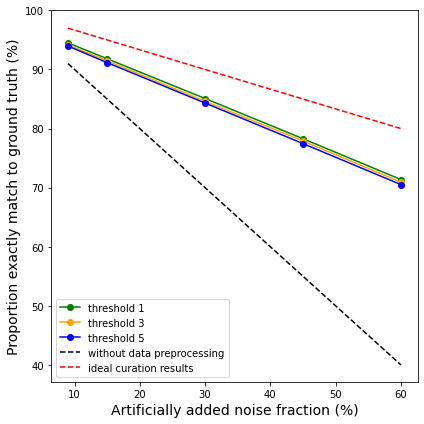

In [18]:
fractions = [3, 5, 10, 15, 20]

fig, ax = plt.subplots(figsize=(6,6))
noise_fractions = [x*3 for x in fractions]
noise_residual = [100 - x for x in noise_fractions]
ideal_residual = [100 - x/3 for x in noise_fractions]
color_dict = {1: "green", 3: "orange", 5: "blue"}

for threshold in thresholds:
    performance = threshold_performance[threshold]
    performance = [100*x for x in performance]
    ax.plot(noise_fractions, performance, color=color_dict[threshold], marker="o", label="threshold "+str(threshold))

ax.plot(noise_fractions, noise_residual, color="black", linestyle='dashed', label="without data preprocessing")
ax.plot(noise_fractions, ideal_residual, color="red", linestyle='dashed', label="ideal curation results")
ax.set_xlabel("Artificially added noise fraction (%)", fontsize=14)
ax.set_ylabel('Proportion exactly match to ground truth (%)', fontsize=14)
ax.set_yticks([40, 50, 60, 70, 80, 90, 100])
ax.set_xticks([10, 20, 30, 40, 50, 60])

ax.legend()
plt.tight_layout()
plt.savefig("../docs/noise_experiments.svg", format="svg")
plt.show()


In [10]:
for reaction_id in prcessed_id2cgr_dict.keys():
    if prcessed_id2cgr_dict[reaction_id] != golden_id2cgr_dict[reaction_id]:
        print(reaction_id, prcessed_id2cgr_dict[reaction_id], golden_id2cgr_dict[reaction_id])

US08003648B2_2
 CCN(CC)[.>-]C(c1ccc(cc1)-c2nc(c(COc3ccc(cc3)C(c4nocc4)CC(N5C(OCC5Cc6ccccc6)=O)=O)s2)C)[->.]Cl c1ccccc1CC2N(C(OC2)=O)C(=O)CC(c3nocc3)c4ccc(cc4)OCc5c(C)nc(s5)-c6ccc(cc6)C([.>-]N(CC)CC)[=>.]O
US05612288_18
 CC(C)S[.>-]c1(c(cccn1)F)[->.]Br CC(C)S[.>-]c1([->.]F)c(cccn1)F
US09133104B2_23
 [O-][N+](=O)c1cc(C([.>-]N)[->.]Cl)ccc1 [O-][N+](=O)c1cc(C([.>-]N)[->.]Br)ccc1
US20110092461A1_30
 c1(ncccc1)-c2c(ccc(c2)N[.>-]C([->.]Cl)(=O)c3cnc(cc3)-n4ncnc4)Cl c1(ncccc1)-c2c(ccc(N[.>-]C(c3cnc(cc3)-n4ncnc4)([->.]O)=O)c2)Cl
US08404673B2_39
 FC(F)(F)c1cc(c(C(NC2C(N[.>-]C3(CCN(CC3)C(C)=O)[->.]Cl)CCCC2)=O)c(C(F)(F)F)c1)OC FC(F)(F)c1cc(OC)c(C(=O)NC2CCCCC2N[.>-]C3(CCN(CC3)C(C)=O)[=>.]O)c(C(F)(F)F)c1
US20150018332A1_47
 FC(F)(F)c1cc(cc(C(F)(F)F)c1)([->.]B(O)O)[.>-]c2(ncnc2)[->.]Br FC(F)(F)c1cc(cc(C(F)(F)F)c1)([.>-]c2([->.]I)cncn2)[->.]B(O)O
US20140113898A1_75
 FC(F)(F)c1cc(C(=O)OC)n([.>-]C([->.]Cl)CBr)n1 FC(F)(F)c1cc(n([.>-]C([->.]Br)CBr)n1)C(=O)OC
US05011992_78
 C(C)N(CC)CCNC(c1cc(Cl)c(cc1O[.>-]

In [ ]:
# In the noise fraction = 20*3% dataset, threshold = 5 processed results
# USPTO patent number: US05612288_18
golden_rxn_smiles = "[CH3:8][CH:9]([CH3:10])[SH:11].F[c:1]1[c:2]([F:3])[cH:4][cH:5][cH:6][n:7]1>>[c:1]1([S:11][CH:9]([CH3:8])[CH3:10])[c:2]([F:3])[cH:4][cH:5][cH:6][n:7]1"
noise_rxn_smiles = "[CH3:8][CH:9]([CH3:10])[SH:11]>>[c:1]1([S:11][CH:9]([CH3:8])[CH3:10])[c:2]([F:3])[cH:4][cH:5][cH:6][n:7]1"
false_processed_rxn_smiles = "[SH:2][CH:3]([CH3:4])[CH3:5].[c:1]1([Br:12])[c:6]([F:7])[cH:8][cH:9][cH:10][n:11]1>>[c:1]1([S:2][CH:3]([CH3:4])[CH3:5])[c:6]([F:7])[cH:8][cH:9][cH:10][n:11]1"
false_template = "[#16:2]-[#6:1]>>Br-[#6:1].[#16:2]"
true_template = "[#16:2]-[#6:1]>>F-[#6:1].[#16:2]"

In [3]:
import sys
sys.path.append("../")
from autotemplate.run_utils import rdchiralRunText_modified
from autotemplate.extract_utils import extract_from_rxn_smiles, canon_remap

rxn_smiles = "CO[C:1](=[O:2])[CH2:3][S:4][CH3:5].[CH3:6][O:7][c:8]1[cH:9][cH:10][c:11]([NH2:12])[c:13]([CH3:14])[c:15]1[CH3:16]>>[C:1]1(=[O:2])[CH:3]([S:4][CH3:5])[c:10]2[cH:9][c:8]([O:7][CH3:6])[c:15]([CH3:16])[c:13]([CH3:14])[c:11]2[NH:12]1"
product = "[C:1]1(=[O:2])[CH:3]([S:4][CH3:5])[c:10]2[cH:9][c:8]([O:7][CH3:6])[c:15]([CH3:16])[c:13]([CH3:14])[c:11]2[NH:12]1"
t = extract_from_rxn_smiles(rxn_smiles)
print(t)
# t = "[C:1]1-[C:2]-[C:3]-[C:4]-[C:5]-[N:6]-1>>[c:1]1=[c:2]-[c:3]=[c:4]-[c:5]=[n:6]-1"
# t = "[#6:1]1-[#6:2]-[#6:3]-[#6:4]-[#6:5]-[#7:6]-1>>[#6:1]1=[#6:2]-[#6:3]=[#6:4]-[#6:5]=[#7:6]-1"
rdchiralRunText_modified(t, product)


[#6:9]1=[#6:4]2-[#7:3]-[#6:1]-[#6:2]-[#6:5]-2=[#6:6]-[#6:7]=[#6:8]-1>>C-O-[#6:1]-[#6:2].[#7:3]-[#6:4]1=[#6:5]-[#6:6]=[#6:7]-[#6:8]=[#6:9]-1


['[C:1](=[O:2])([CH2:3][S:4][CH3:5])[O:18][CH3:17].[cH:6]1[cH:7][c:8]([O:9][CH3:10])[c:11]([CH3:12])[c:13]([CH3:14])[c:15]1[NH2:16]']

In [7]:
canon_remap('[CH3:1][C:2]([OH:3])([CH2:4][OH:5])[c:6]1[cH:7][cH:8][n:9][cH:10][cH:11]1')

'CC(O)(CO)c1ccncc1'

In [1]:
import sys
sys.path.append("../")
from autotemplate.run_utils import rdchiralRunText_modified
from autotemplate.extract_utils import extract_from_rxn_smiles, canon_remap

rxn_smiles = "O=C(O[OH:1])c1cccc(Cl)c1.[CH3:2][c:3]1[n:4][c:5]([Br:6])[cH:7][cH:8][c:9]1[F:10]>>[O-:1][n+:4]1[c:3]([CH3:2])[c:9]([F:10])[cH:8][cH:7][c:5]1[Br:6]"
product = "[O-:1][n+:4]1[c:3]([CH3:2])[c:9]([F:10])[cH:8][cH:7][c:5]1[Br:6]"
t = extract_from_rxn_smiles(rxn_smiles)
print(t)

rdchiralRunText_modified(t, product)

[#7;+1:2]-[#8;-1:1]>>Cl-C1=C-C(-C(=O)-O-[#8;+0:1])=C-C=C-1.[#7;+0:2]


['[OH:1][O:17][C:15]([c:14]1[cH:13][c:12]([Cl:11])[cH:20][cH:19][cH:18]1)=[O:16].[n:2]1[c:3]([CH3:4])[c:5]([F:6])[cH:7][cH:8][c:9]1[Br:10]']

In [31]:
import re

def map2label(labels):
    map2label = dict ()
    for label in labels:
        mapnum = re.search(r'\[(.*?)\:(.*?)\]', label).group(2)
        charge_list = re.findall(r'[+-]\d+', label)
        if charge_list:
            charge = charge_list[0]
        else:
            charge = "0"
        map2label.update({mapnum: (label, charge)})
    return map2label

def neutralize_reactant_fragments(reactant_fragments, product_fragments):
    reactant_fragments = "(Cl-C1=C-C(-C(=O)-O-[#8:1])=C-C=C-1).([#7:4])"
    product_fragments = "([#7;+1:4]-[#8;-1:1])"
    r_labels = re.findall(r'\[[^\[\]]+\]', reactant_fragments)
    p_labels = re.findall(r'\[[^\[\]]+\]', product_fragments)
    if (not p_labels) or (not r_labels):
        return reactant_fragments, product_fragments

    new_reactant_fragments = reactant_fragments

    r_map2label = map2label(r_labels)
    p_map2label = map2label(p_labels)

    for mapnum, p_values in p_map2label.items():
        p_label, p_charge = p_values
        r_values = r_map2label.get(mapnum)
        if r_values == None:
            continue
        else:
            r_label, r_charge = r_values
            if (p_charge != "0") and (r_charge == "0"):
                new_r_label = r_label.replace(":", ";+0:")
                new_reactant_fragments = new_reactant_fragments.replace(r_label, new_r_label)

    return new_reactant_fragments, product_fragments


In [16]:
match = re.search(r'\[(.*?)\:(.*?)\]', '[#8;+4;D3;H1:142]')
match.group(2)

'142'

In [9]:
import re
from rdkit import Chem

# def SmartsMolWithFormalCharge(smarts):
#     """
#     [O+]-[#6:3]=[#7;+1:4]=[#7;-2:5]
#     """
smarts = "[O+]-[#6:3]=[#7;+1:4]=[#7;-2:5]-[#6;+0:6]"
mol = Chem.MolFromSmarts(smarts)
# smarts_convert = ']'.join([x for x in smarts.split('[') if (':' in x) and (x != ':')])
# smarts_convert = [x for x in smarts_convert.split(']') if (':' in x) and (x != ':')]
smarts_convert = re.findall('\[([^]]*)\]', smarts)
smarts_convert = [x for x in smarts_convert if ':' in x]
formalcharge_dict = dict()
for symbol in smarts_convert:
    charge = re.search('([-+]+[0-9]?)', symbol)
    if charge:
        mapnum = int(re.search('\:([0-9]+)', symbol).group()[1:])
        formalcharge_dict.update({mapnum: int(charge.group())})

for atom in mol.GetAtoms():
    mapnum = int(atom.GetAtomMapNum())
    if mapnum and (mapnum in formalcharge_dict.keys()):
        atom.SetFormalCharge(formalcharge_dict[mapnum])

    # return mol

In [6]:
import sys
sys.path.append("../")
from autotemplate.run_utils import rdchiralRunText_modified
from autotemplate.extract_utils import extract_from_rxn_smiles, canon_remap

rxn_smiles = "CO[C:1](=[O:2])[CH2:3][S:4][CH3:5].[NH2:6][c:7]1[cH:8][cH:9][c:10]([C:11]([F:12])([F:13])[F:14])[cH:15][cH:16]1>>[C:1]1(=[O:2])[CH:3]([S:4][CH3:5])[c:8]2[c:7]([cH:16][cH:15][c:10]([C:11]([F:12])([F:13])[F:14])[cH:9]2)[NH:6]1"
product = "[C:1]1(=[O:2])[CH:3]([S:4][CH3:5])[c:8]2[c:7]([cH:16][cH:15][c:10]([C:11]([F:12])([F:13])[F:14])[cH:9]2)[NH:6]1"
t = extract_from_rxn_smiles(rxn_smiles)
print(t)

rdchiralRunText_modified(t, product)



[#6:3]-[#6:2]-[#6:1]-[#7:4]>>C-O-[#6:1]-[#6:2].[#6:3].[#7:4]


['[C:1](=[O:2])([CH2:3][S:4][CH3:5])[O:18][CH3:17].[cH:6]1[c:7]([NH2:16])[cH:8][cH:9][c:10]([C:11]([F:12])([F:13])[F:14])[cH:15]1']

In [3]:
import re

# 定義你的字串
s = "(Cl-C1=C-C(-C(=O)-O-[#8:1])=C-C=C-1).([#7:4]-[Sr])"

# 使用 re.findall() 函式來找出所有符合條件的字串
result = re.findall(r'\[[^\[\]:]*:[^\[\]]*\]', s)

print(result)

['[#8:1]', '[#7:4s]']
